In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from datetime import datetime, timedelta, date

warnings.filterwarnings("ignore")

np.random.seed(1000)

path = r"C:\Users\LENOVO\Desktop\extracted_data\Churn_Modelling.csv"

df = pd.read_csv(path)

print(df.shape)

df.head()

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
!pip install tabulate


In [6]:
df.info()

print()

print(df[['CustomerId', 'Surname', 'Geography', 'Gender', 'Age', 'Tenure', 'NumOfProducts', 'IsActiveMember', 'Exited', ]].agg(pd.Series.nunique).to_frame('counts').to_markdown())

print()

print('Duplicate row counts', len(df[df.duplicated()]))

print()
ndf = df.isnull().agg(['sum', 'count']).T
ndf.columns = ['null_counts', 'Total Records']
print(ndf.to_markdown())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB

|                |   counts |
|:---------------|---------:|
| CustomerId     |    10000 |
| S

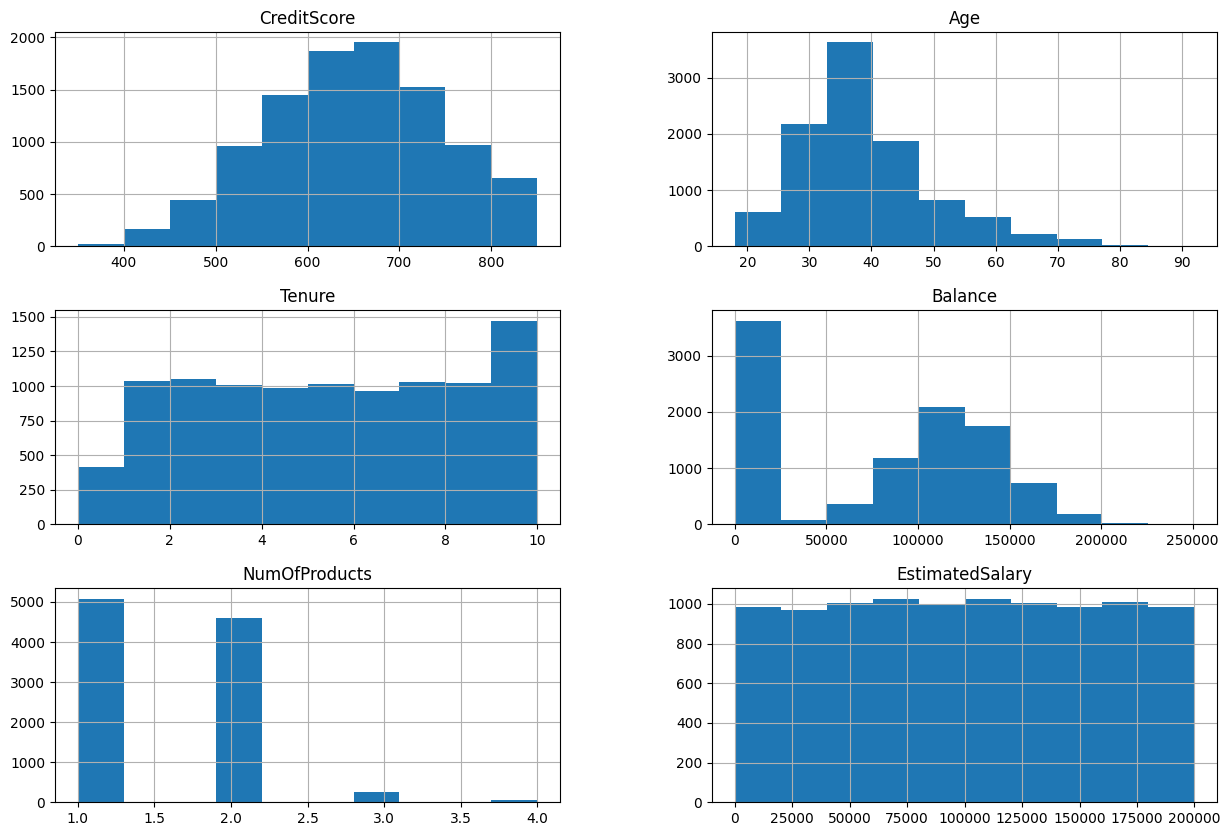

In [7]:
# Histograms for numerical features
df.hist(column=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary'], figsize=(15, 10))
plt.show()

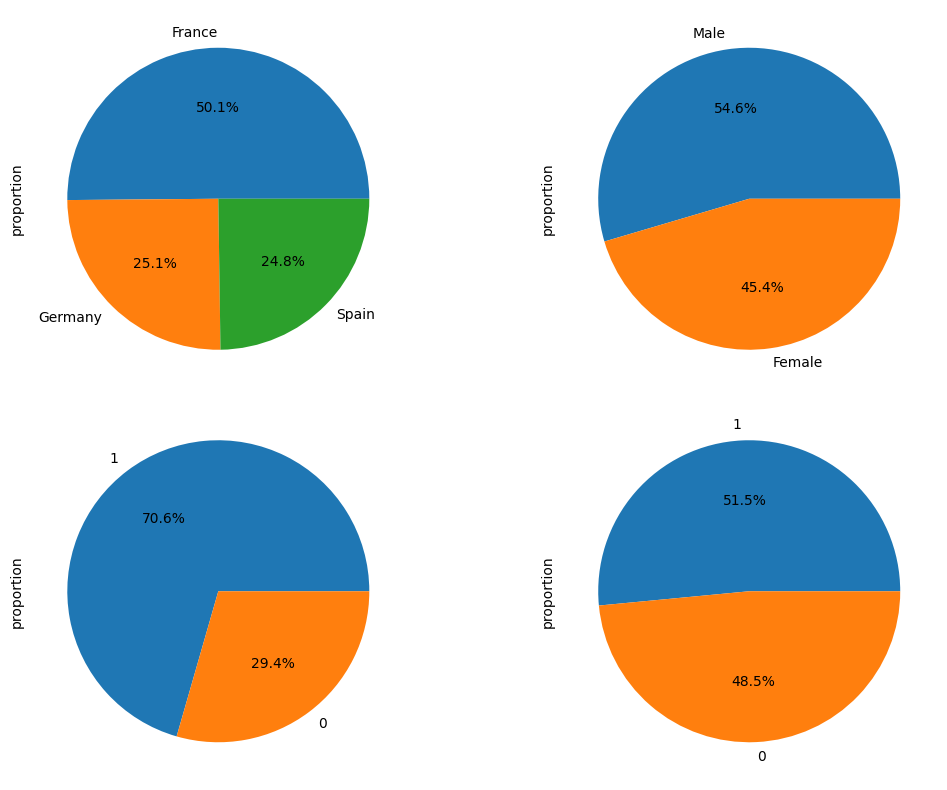

In [8]:
# Bar plots for categorical features
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

df['Geography'].value_counts(normalize=True).plot.pie(ax=axes[0][0], autopct='%1.1f%%', )
df['Gender'].value_counts(normalize=True).plot.pie(ax=axes[0][1], autopct='%1.1f%%', )
df['HasCrCard'].value_counts(normalize=True).plot.pie(ax=axes[1][0], autopct='%1.1f%%', )
df['IsActiveMember'].value_counts(normalize=True).plot.pie(ax=axes[1][1], autopct='%1.1f%%', )

plt.tight_layout()
plt.show()

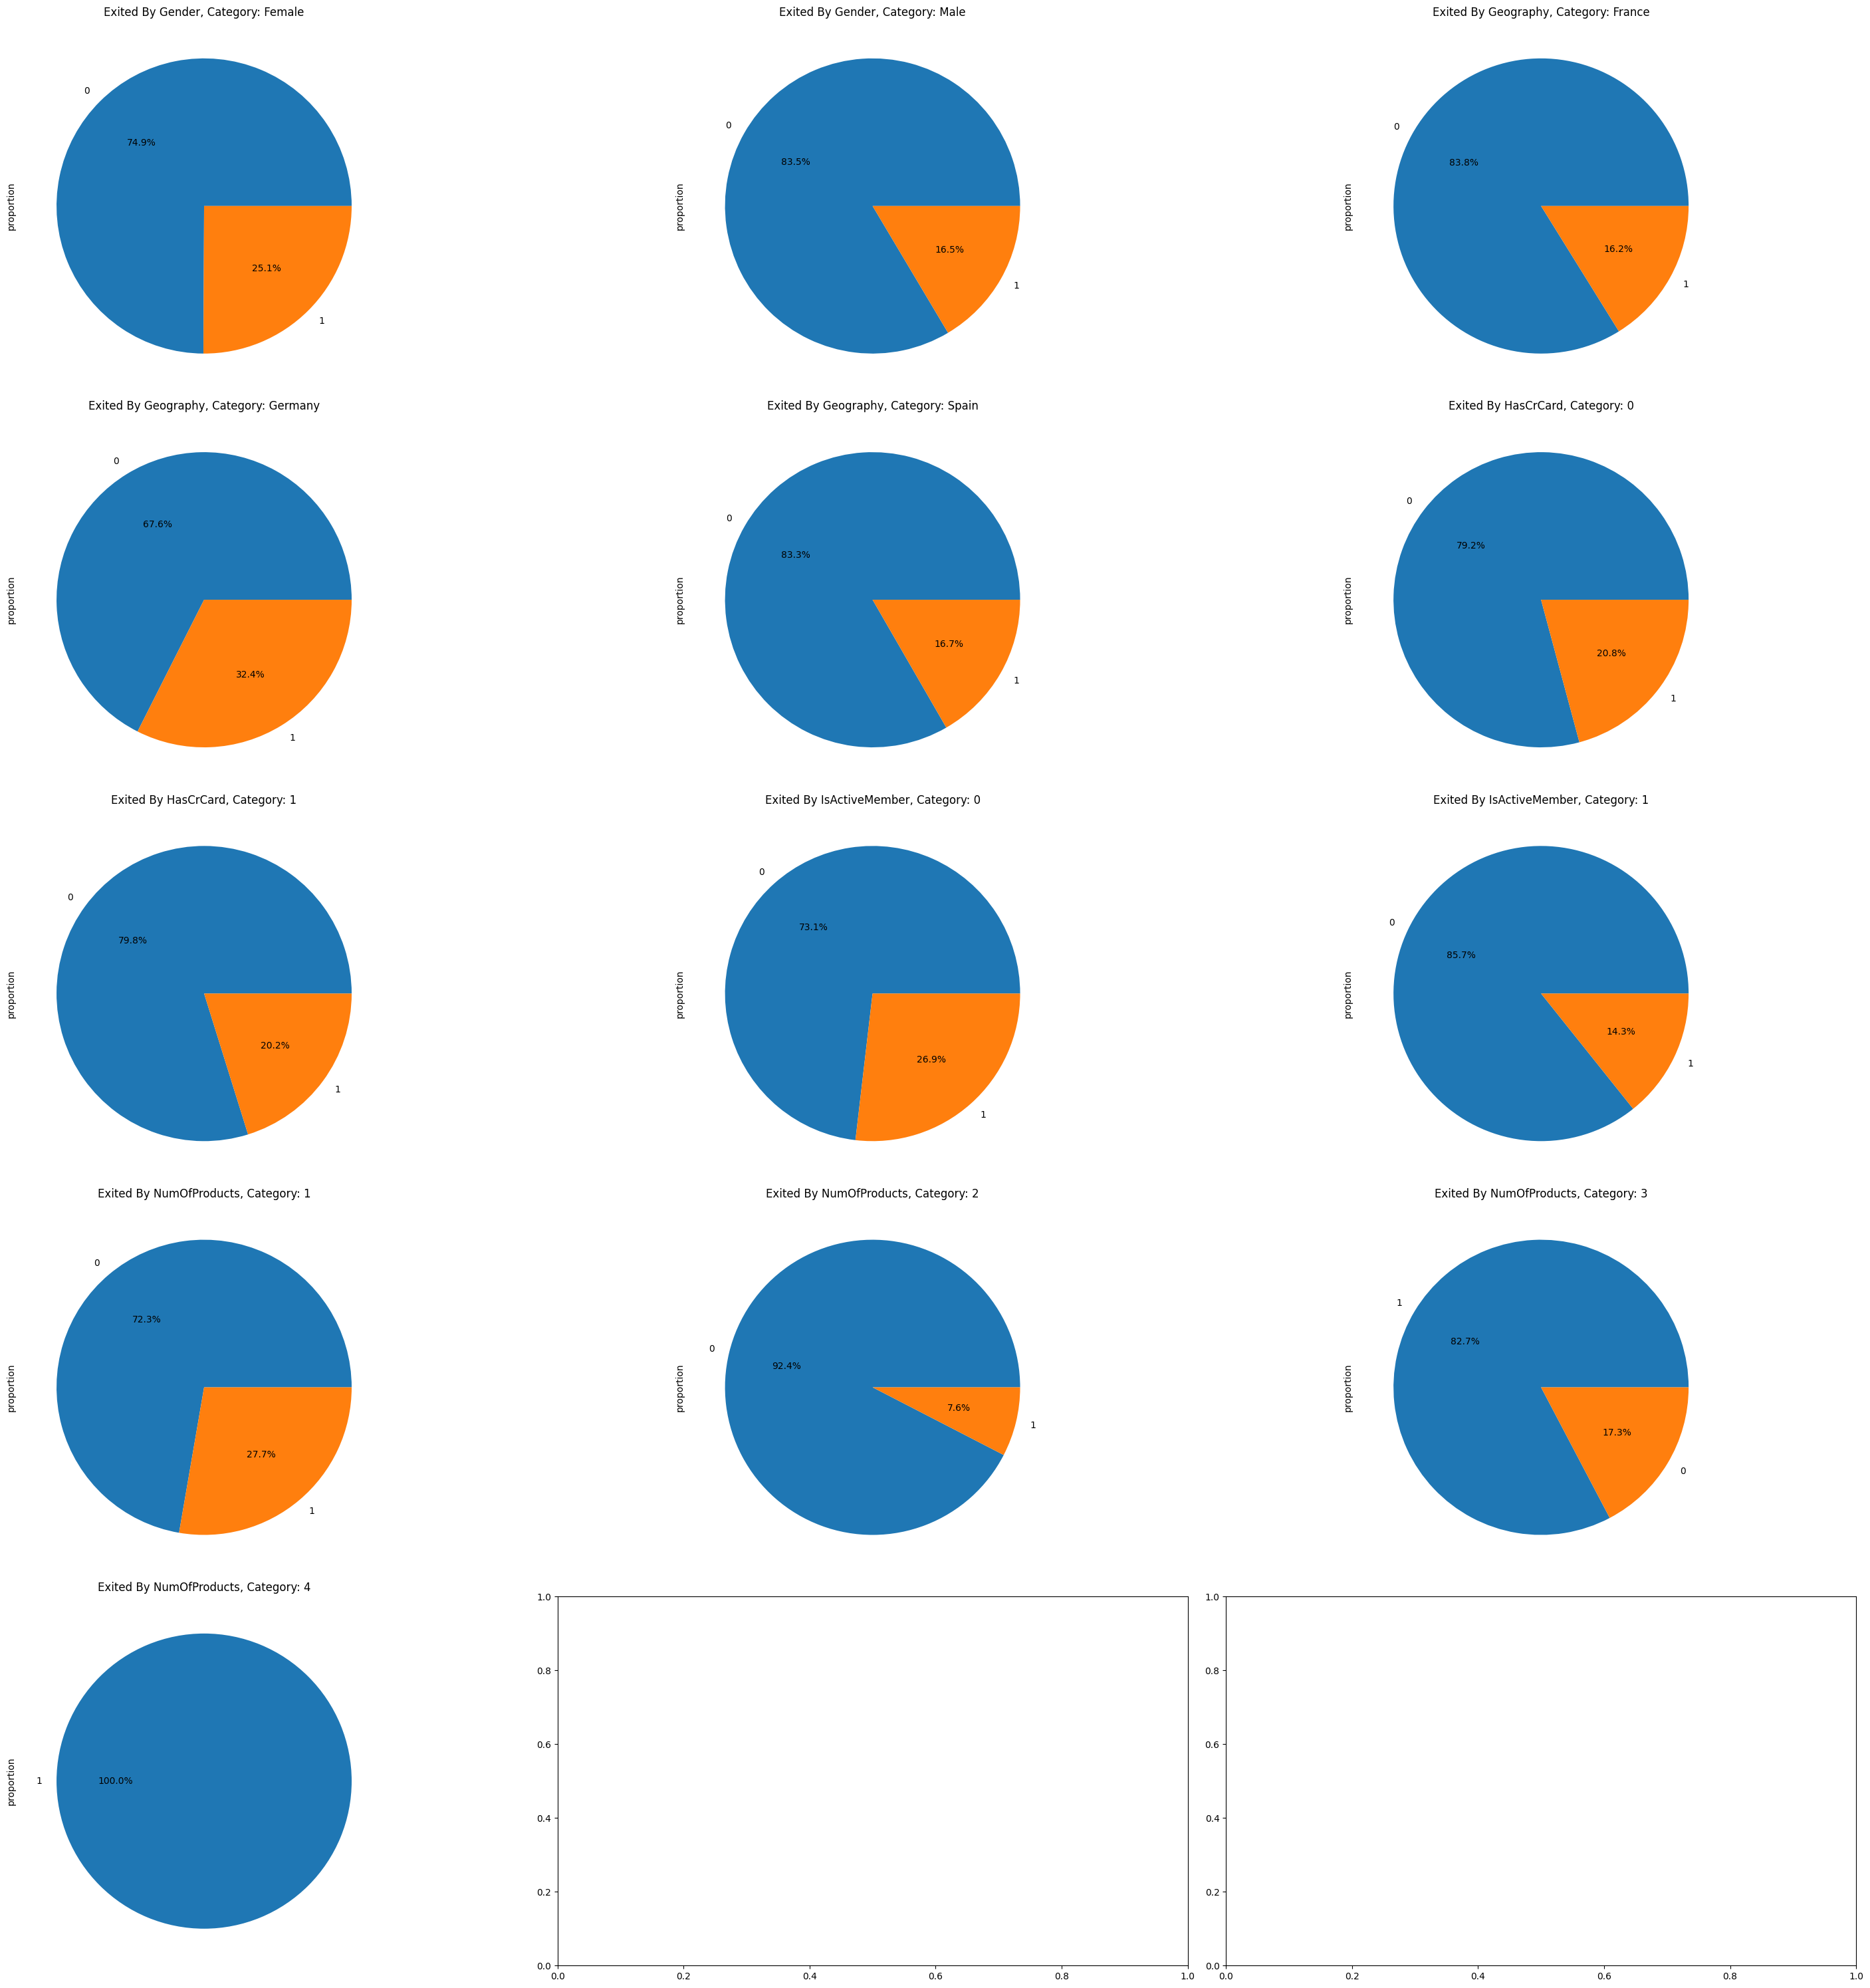

In [9]:
# Explore churn rate by category
key_columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts']
combinations = sorted(
    [
        (col, key, group) 
        for col in key_columns 
        for key, group in df.groupby(col)], 
    key=lambda x: (x[0], x[1])
)

fig, axes = plt.subplots((len(combinations)//3)+1, 3, figsize=(30, 30))

axes = axes.flatten()

for i, (col, key, group) in enumerate(combinations):
    group['Exited'].value_counts(normalize=True).plot.pie(ax=axes[i], autopct='%1.1f%%', )
    axes[i].set_title(f'Exited By {col}, Category: {key}')

plt.tight_layout()
plt.show()

In [11]:
!pip install --upgrade scikit-learn


^C
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
    --------------------------------------- 0.3/11.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.1 MB 1.6 MB/s eta 0:00:07
   --- ------------------------------------ 1.0/11.1 MB 2.0 MB/s eta 0:00:05
   ----- ---------------------------------- 1.6/11.1 MB 2.1 MB/s eta 0:00:05
   ------- -------------------------------- 2.1/11.1 MB 2.3 MB/s eta 0:00:04
   --------- ------------------------------ 2.6/11.1 MB 2.2 MB/s eta 0:00:04
   ----------- ---------------------------- 3.1/11.1 MB 2.2 MB/s eta 0:00:04
   ------------- -------------------------- 3.7/11.1 MB 2.4 MB/s eta 0:00:04
   ---------------- ----------------------- 4.5/11.1 MB 2.5 MB/s eta 0:00:03
   ------------------ --------------------- 5.2/11.1 MB 2.7 MB/s eta 0:00:03
   --------------------- ------------------ 6.0/11.1 MB 2.8 MB/s eta 0:00:02
   ------------------------ --------------- 6.8/11.1 MB 2.9 MB/s eta 0:00:02
   -------

  You can safely remove it manually.


In [12]:
from sklearn.ensemble import RandomForestClassifier


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# Separate features (X) and target variable (y)
X = df.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1)  # Exclude irrelevant columns
y = df['Exited']

# One-hot encode categorical features
X = pd.get_dummies(X, columns=['Geography', 'Gender'], drop_first=True)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- Filter Method (SelectKBest) ---
selector_kbest = SelectKBest(f_classif, k=5)  # Select top 5 features
X_train_kbest = selector_kbest.fit_transform(X_train, y_train)
X_test_kbest = selector_kbest.transform(X_test)

# --- Wrapper Method (RFE) ---
estimator = LogisticRegression(random_state=42)  # Use logistic regression as the estimator
selector_rfe = RFE(estimator, n_features_to_select=5)  # Select top 5 features
X_train_rfe = selector_rfe.fit_transform(X_train, y_train)
X_test_rfe = selector_rfe.transform(X_test)

# --- Embedded Method (Random Forest Feature Importance) ---
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
importances = rf_model.feature_importances_
indices = importances.argsort()[::-1]  # Get indices of features sorted by importance

# Print feature rankings from Random Forest
print("Feature Ranking:")
for f in range(X.shape[1]):
     print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

Feature Ranking:
1. Age (0.236922)
2. EstimatedSalary (0.147558)
3. CreditScore (0.143338)
4. Balance (0.141612)
5. NumOfProducts (0.131486)
6. Tenure (0.082080)
7. IsActiveMember (0.040725)
8. Geography_Germany (0.026190)
9. HasCrCard (0.018454)
10. Gender_Male (0.018421)
11. Geography_Spain (0.013214)
